<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-Report" data-toc-modified-id="Project-Report-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project Report</a></span><ul class="toc-item"><li><span><a href="#Basics-of-Mobile-Robotics,-MICRO-452" data-toc-modified-id="Basics-of-Mobile-Robotics,-MICRO-452-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Basics of Mobile Robotics, MICRO-452</a></span><ul class="toc-item"><li><span><a href="#Mehdi-Krichen,-Francesco-Nonis,-Michael-Richter,-Vincent-Philippoz,-Nathan-Decurnex" data-toc-modified-id="Mehdi-Krichen,-Francesco-Nonis,-Michael-Richter,-Vincent-Philippoz,-Nathan-Decurnex-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Mehdi Krichen, Francesco Nonis, Michael Richter, Vincent Philippoz, Nathan Decurnex</a></span></li></ul></li></ul></li><li><span><a href="#Environment" data-toc-modified-id="Environment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Environment</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation</a></span><ul class="toc-item"><li><span><a href="#Vision" data-toc-modified-id="Vision-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Vision</a></span><ul class="toc-item"><li><span><a href="#Illustrations" data-toc-modified-id="Illustrations-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Illustrations</a></span></li><li><span><a href="#Real-Code-testing" data-toc-modified-id="Real-Code-testing-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Real Code testing</a></span></li></ul></li><li><span><a href="#Path-Planning" data-toc-modified-id="Path-Planning-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Path Planning</a></span><ul class="toc-item"><li><span><a href="#General-overview" data-toc-modified-id="General-overview-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>General overview</a></span></li><li><span><a href="#Details-on-the-offline-section" data-toc-modified-id="Details-on-the-offline-section-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Details on the offline section</a></span></li><li><span><a href="#Results-of-the-offline-part" data-toc-modified-id="Results-of-the-offline-part-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Results of the offline part</a></span></li><li><span><a href="#Details-on-the-online-part" data-toc-modified-id="Details-on-the-online-part-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Details on the online part</a></span></li><li><span><a href="#Results-of-the-online-part" data-toc-modified-id="Results-of-the-online-part-3.2.5"><span class="toc-item-num">3.2.5&nbsp;&nbsp;</span>Results of the online part</a></span></li></ul></li><li><span><a href="#Global-Navigation" data-toc-modified-id="Global-Navigation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Global Navigation</a></span></li><li><span><a href="#Local-Navigation" data-toc-modified-id="Local-Navigation-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Local Navigation</a></span><ul class="toc-item"><li><span><a href="#Avoidance-Strategie" data-toc-modified-id="Avoidance-Strategie-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Avoidance Strategie</a></span></li><li><span><a href="#Choosing-if-we-follow-the-obstacle-on-the-rigth-or-on-the-left" data-toc-modified-id="Choosing-if-we-follow-the-obstacle-on-the-rigth-or-on-the-left-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Choosing if we follow the obstacle on the rigth or on the left</a></span></li><li><span><a href="#Regulators-to-follow-the-side-of-an-obstacle" data-toc-modified-id="Regulators-to-follow-the-side-of-an-obstacle-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Regulators to follow the side of an obstacle</a></span></li><li><span><a href="#Determine-if-the-obstacle-is-cleared" data-toc-modified-id="Determine-if-the-obstacle-is-cleared-3.4.4"><span class="toc-item-num">3.4.4&nbsp;&nbsp;</span>Determine if the obstacle is cleared</a></span></li></ul></li><li><span><a href="#Localization" data-toc-modified-id="Localization-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Localization</a></span><ul class="toc-item"><li><span><a href="#How-the-localization-works" data-toc-modified-id="How-the-localization-works-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>How the localization works</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-3.5.1.1"><span class="toc-item-num">3.5.1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Odometry" data-toc-modified-id="Odometry-3.5.1.2"><span class="toc-item-num">3.5.1.2&nbsp;&nbsp;</span>Odometry</a></span></li><li><span><a href="#Measurement" data-toc-modified-id="Measurement-3.5.1.3"><span class="toc-item-num">3.5.1.3&nbsp;&nbsp;</span>Measurement</a></span></li><li><span><a href="#Why-a-particle-filter-?" data-toc-modified-id="Why-a-particle-filter-?-3.5.1.4"><span class="toc-item-num">3.5.1.4&nbsp;&nbsp;</span>Why a particle filter ?</a></span></li></ul></li><li><span><a href="#Particle-filter" data-toc-modified-id="Particle-filter-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Particle filter</a></span></li><li><span><a href="#The-system-of-classes" data-toc-modified-id="The-system-of-classes-3.5.3"><span class="toc-item-num">3.5.3&nbsp;&nbsp;</span>The system of classes</a></span><ul class="toc-item"><li><span><a href="#Moving_point" data-toc-modified-id="Moving_point-3.5.3.1"><span class="toc-item-num">3.5.3.1&nbsp;&nbsp;</span>Moving_point</a></span></li><li><span><a href="#Particle" data-toc-modified-id="Particle-3.5.3.2"><span class="toc-item-num">3.5.3.2&nbsp;&nbsp;</span>Particle</a></span></li><li><span><a href="#Pose" data-toc-modified-id="Pose-3.5.3.3"><span class="toc-item-num">3.5.3.3&nbsp;&nbsp;</span>Pose</a></span></li></ul></li><li><span><a href="#Hyperparameters-:-How-to-make-the-code-work-on-my-Thymio-?" data-toc-modified-id="Hyperparameters-:-How-to-make-the-code-work-on-my-Thymio-?-3.5.4"><span class="toc-item-num">3.5.4&nbsp;&nbsp;</span>Hyperparameters : How to make the code work on my Thymio ?</a></span><ul class="toc-item"><li><span><a href="#Procedure-1:-Movements-1" data-toc-modified-id="Procedure-1:-Movements-1-3.5.4.1"><span class="toc-item-num">3.5.4.1&nbsp;&nbsp;</span>Procedure 1: Movements 1</a></span></li><li><span><a href="#Procedure-2:-Colors" data-toc-modified-id="Procedure-2:-Colors-3.5.4.2"><span class="toc-item-num">3.5.4.2&nbsp;&nbsp;</span>Procedure 2: Colors</a></span></li><li><span><a href="#Procedure-3:-Movements-2" data-toc-modified-id="Procedure-3:-Movements-2-3.5.4.3"><span class="toc-item-num">3.5.4.3&nbsp;&nbsp;</span>Procedure 3: Movements 2</a></span></li></ul></li><li><span><a href="#Interfacing-:-How-to-use-the-localisation-module-?" data-toc-modified-id="Interfacing-:-How-to-use-the-localisation-module-?-3.5.5"><span class="toc-item-num">3.5.5&nbsp;&nbsp;</span>Interfacing : How to use the localisation module ?</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Annexes" data-toc-modified-id="Annexes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Annexes</a></span></li></ul></div>

# Project Report

## Basics of Mobile Robotics, MICRO-452

### Mehdi Krichen, Francesco Nonis, Michael Richter, Vincent Philippoz, Nathan Decurnex

# Environment

Our environment in which our thymio will evolve is a rectangle space composed of two A0 sheet. The size was choosen so that the Thymio could perform efficient and visible local avoidance moves.
The background is green to imitate grass. It has been set to a uniform dark green to not intefer with the thymio's ground sensors (to contrast with the yellow of the crossroads).
The world is also compose of roads and crossroads. The roads will be seen as obstacles. Obviously, the robot can use the crossroads to pass roads. The design of these modules stay simple: rectangular shapes. This is crucial to simplify the vision part. The crossroads were initially yellow and gray like real ones. But we further choose to change them to uniform yellow. This simplified the ground sensors measurements to update the filter, but made their detection in the vision part more difficult. 

The size of the crossroads and road were chosen to approximately be squares of Thymio's dimensions. At the beginning, we wanted to have another Thymio following the white line in the middle of the road. But the main part of the project took us more time than planned.

<img src='img.jpg' width="400">

# Implementation
The implementation requires several libraries which can all be installed by running the following block.

In [12]:
!pip install pandas matplotlib numpy import-ipynb opencv-python pyvisgraph

## Vision

The vision part of the project is essentially used at initialization. It will be used to build an initial obstacle map of the environment. The processing will also find the Thymio initial location and orientation, and the target to reach.

At the start, a picture of the whole environment is taken. The first step is to trim the initial image to obtain a frame with only the environment. We first tried to found the 4 corners of the map in order to perform a reshaping to account for perspective. But the task of finding the corners was not so simple for several reasons. We tried to have one particular shape on each corner so that we could perform template matching with it. But it was hard to detect 4 time the same shape in our environmental conditions; even by filtering our image, other shapes in our environment had regularly more correlation with the template than the real one. We thus thought to change the shape for each corner, but we were limited in the choice of easy distinguishable colors and shape. Moreover, choosing a particular shape could make hard the template detection due to perspective. It why we wanted to have circles. A last factor that made hard edge detection via templatematching is that we do not know the exact size of the template on the image; template matching is very sensitive to the size of the object we are trying to match. In other word, to make work correctly template matching, we should know in advance the size in pixels of our template on the image.  

Before trying some other fancy techniques, we wanted to have a backup. It was to simply mask the green background region of our environment via template matching. This allowed us to have a rather good cropping of the picture as long as it has been taken far away enough; to avoid having straight line deformations. The result was good enough to keep it. We could have tried line detection, but the roads or the floor pattern outside of our map would have also been detected. Sometime to stay simple is the good solution.  

Once the image trimmed, Template matching is again used to detect all the objects on the map. The 4 patterns of turning roads (4 orientations) and the two orientation of straight lines were used to detect the roads. Even with such a simple design, the sensitivity and selectivity of template matching was quite poor. Luminosity is also a decisive factor when trying to detect objects. A lot of hyperparameter needed to be tuned in order to achieve a sufficient road detection. We could have gone for simple uniform gray roads: it would have simplified the template search (also faster computation) and improved the selectivity/sensitivity. But at the beginning, a second robot was planned to follow the road: the central white line would have been used to track the path. 

The crossroads were detected by the same way as the roads. As expected, the result is also highly depending on the tuning of hyperparameters and lighting. The target position was finally decided to be a simple circle. This allowed no orientation dependence: allowing one single template search.

Finally, the Thymio robot is detected thanks to two very small circle placed strategically at the back and front of the robot. Once the circles detected by template matching, a simple calculation is done to obtain the robot hole's position and orientation. We also tried a data driven method: Convolutionnal Neural Network (CNN) and Support Vector Regression to extract the robot position from the image as input. The major issue was to collect data and label it. Simple trials with 25 data points yielded unsatisfying results and stopped our search in this direction. 


### Illustrations

In this section, we present sub-optimal results and particularities that can be observed from.

![env](images/angle1.jpg)

![env](images/angle12.jpg)

Above are illustrations on how sensitive the template matching, for a the road angle, is. The results for the four different orientation yielded the same kind of results showed above. This may be due to deformation of roads on the bottom of the image. The template matches better straight roads than certain correct road on the bottom.

This situation only happens with real big images. When we were testing on smaller scaled map or screenshots of the map on the computer, this did not happen. This shows how image processing becomes harder in real conditions. We think that the template matching could have been improved a little bit: by taking the template image with the same camera that takes the real pictures shown. Currently, the template are the computer image (numerical ones).

This problem was essentially solved by using the high sensitivity of the template matching of the straight roads. This in some way is a bit cheating, but as long as it works...
It was even our final way to find all the roads because it was the more robust we found. In fact the angle roads detection is useless at the end.

![env](images/rd2.jpg)

![env](images/road44.jpg)

We can see at which point, even the wrong orientation of the road can be detected easily. Some crossroads are also captured in the process. Even some opposite orientation roads are detected while the correct orientation is not (see second illustration on the bottom, the template orientation can be deduced: horizontal roads). 

![env](images/psg2.jpg)

Note the crossroad design was change finally.
Of course the same effect appears also for crossroads. The right crossroad is much more detected than the left one. If we want absolutely to detect the two horizontal crossroad, we need to decrease the threshold. This has a direct effect on the right crossroad: it appears larger; even some portion of the right crossroad combined to the road is more detectable than the left crossroad... 

The lighting is even more affecting the results than previously. We think it is because when the yellow is well lighted, it is almost seen like white from the camera. The figure shows a little bit this effect for the crossroad on the left of the image that appears brighter than the other ones.

We finally decided to change the design of the crossroad to simplify the filter localization; uniform yellow. But it made their detection much harder. Finally, as the crossroads had no more white line in the middle, the road template matching could not anymore find them. So we could use only the straight lines pattern to extract all the road and by extent the crossroads; where the roads are not detected it is seen like a hole where the robot is allowed to pass.

### Real Code testing

If you want a real test implementation of the Image Processing part, you can run the cell below. It will print the current progression of the process and show several plots showing each step.

In [ ]:
%run IP/IP_methods.ipynb 
(x,y), orientation = pipeline_IP(plot=True)
print(f'position of thymio is ({x},{y}), the x position is on the horizontal axis and y on the vertical axis. The zero is on the bottom left')
print(f'its orientation is {orientation} [rad] (defined as [0,2Pi] with respect to the horizontal axis)') 

Globally, image processing is very hard. Robust method to lightning, object orientation, deformation or camera type etc.. do not really exist. All lot of testing needed to be done.

## Path Planning

### General overview
Many algorithms exist for path planning. The one used in this project is the vision graph method. It has many disadvantages when building the map, but once it is built, the computation is very quick. Other algorithms were explored, but in an effort to shorten the report, they are explored in the _PathPlanning.ipynb_ notebook.

This whole algorithm is subdivided into two distinct parts. The first is the __offline__ part. This part is designed to be run only at the start of the run. It encapsulates all the steps in building a vision graph with all the nodes from a binary image of the obstacles. As it is offline, it doesn't require speed in execution. Therefore this wasn't a design constraint.
The second part is the __online__ part. It regroups the calculation of the shortest path from a point A to a Point B in the given vision graph (built by the offline part). As this section of the code could be run during the actual run of the robot, execution time is a constraint.

The first preliminary step is to define a coordinate system. We choose an arbitrary corner as the origin and choose the max axis coordinates to be the physical dimensions of our map in mm:
> 2*A0 : 1682 x 1188 mm

Once chosen, we can read the CSV file of the obstacles produced by the vision module of the project. First, the image is read, then saved for ease of use and easy access. Then the image is treated to reduce the effect of noise and converted to grayscale. The contours of each obstacle are then found noting carefully to which obstacle they belong. The obstacles are grown of the radius of a circle drawn around the Thymio to avoid the Thymio colliding with the obstacles. Then a vision graph is built according to the grown obstacles. Finally an _online_ part is defined, taking the position of the Thymio and the vision graph calculated before, the shortest path (according to norm 2 distances) is found between the start and the goal position.

All of this can be summarized in the figure below:
<img src='images_for_report/Global overview path planning.jpg' width="800">
The blue text represents what is transferred.

### Details on the offline section
As said above, the offline part regroups all the graph building sections of this part of the project. To separate further the problem, we will follow the division of the graph above. 
1. CSV Image to grayscale array
> The first part is to read the actual map given by the vision graph. Some operation are conducted on the data to reduce the effect of noise (blurring), to make the image binary (thresholding). Finally we resize the image to get the coordinates in mm.
2. Find contours of obstacles 
> The second part is to find the obstacles. Fortunately, in the openCV library has a very handy functions called :```cv2.findContours```
> This allows us, by choosing the right options to obtain corners of the obstacles as well as which obstacle those corners belong to. Then we run another useful openCV function to approximate the polygons. This allows to simplify the graph.
3. Grow the obstacles
> The next step is to grow the obstacles. By finding the direction of the two segments connected to a given vertex, we can multiply it by the radius of the Thymio and move the point to be outside the polygon. As the polygons are not convex, we must check if the points are correctly placed. We do this for every vertex of every obstacle. Then we check if the points are outside of the map. If they are, we add a margin to block the Thyimo from choosing a path that exists the map.
4. Build Vision Graph
> The final step of the offline part is to build the actual vision graph. To do this, we use the library _pyvisgraph_ (see the PathPlanning.ipynb for link). This library calculates the best path using the Dijkstra algorithm with norm 2 distances. This library allows also to save the graph. This is done for easy access. 
5. Find Goal
> An added part is to find the goal. This is done again by using the ```cv2.findContours``` function and finding the centroïd of the polygon.

### Results of the offline part
We can evaluate the effectiveness of the graph building by plotting the results of the graph building for an image. A code cell can be found below, it contains a lot of configuration but generally it allows to visualize the results.

100%|██████████| 5/5 [00:00<00:00, 39.16it/s]


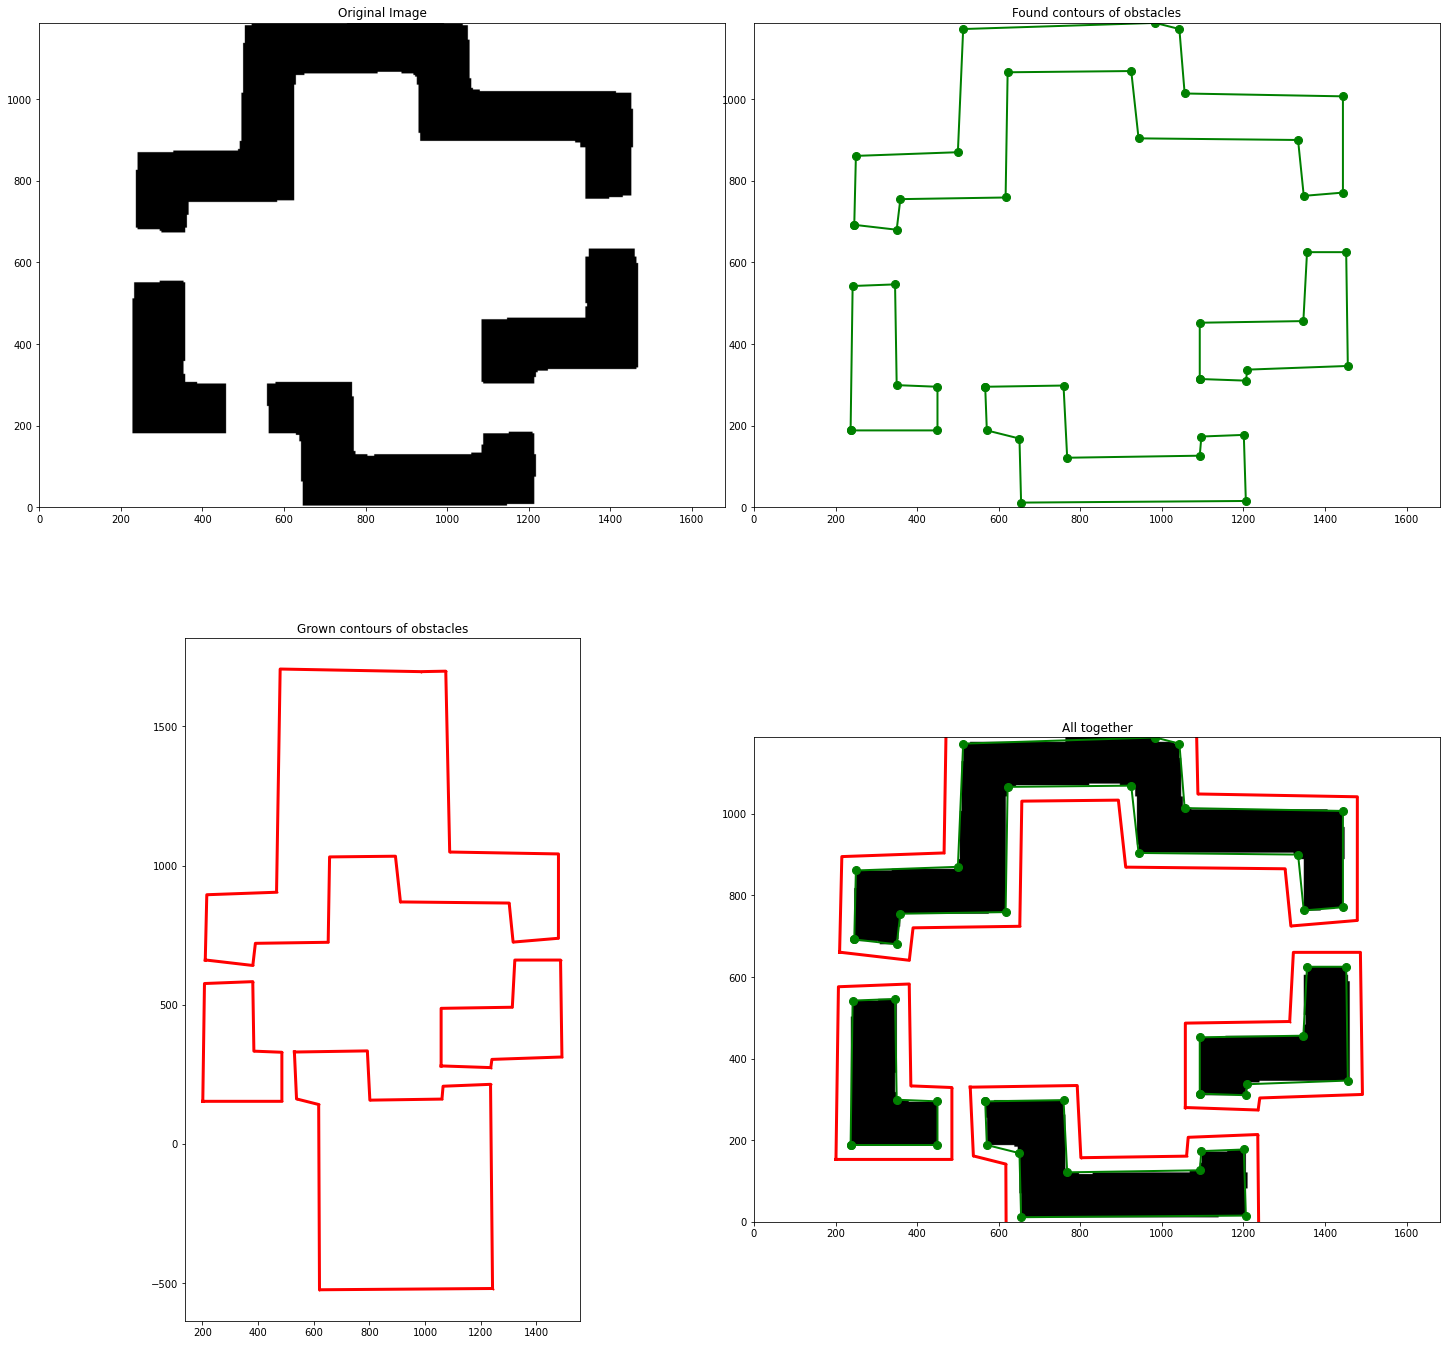

[1587, 530]


In [31]:
#import import_ipynb
#%run PathPlanning.ipynb
stop = PathPlanning_offline(graph_name = "output_for_report/graph",
                            csvPath = "output_for_report/roads.csv",
                            savePath = "output_for_report/csvIM.png",
                            goalPath = "output_for_report/goal.csv" ,
                            goalsavePath = "output_for_report/csvIM_goal.png",
                            desired_size = [2*841, 1188], #size of 2 A0 sheets 
                            smoothing_factor = 0.01,
                            radius = 50,
                            epsilon = 500,
                            plot = True,
                            verbose= False)
print(stop)

### Details on the online part
The online part is simply the part that calculates the shortest path from the vision graph calculated in the offline part. This is again done with the _pyvisgraph_ library. This library provides a simple function to calculate the shortest path. This gives back an array of coordinates. 
### Results of the online part
We can also plot the results of the shortest path fond with the green circle being the Thymio and the red cross the goal. Here we choose arbitrary points for the start and goal to be able to change them and observe the different paths computed.

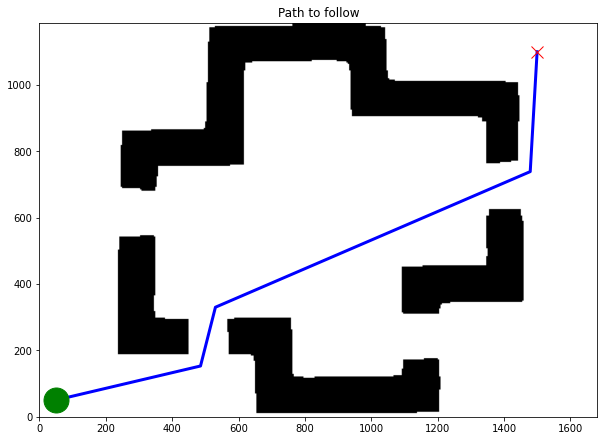

In [7]:
start = [50, 50]
goal = [1500, 1100]
fig = plt.figure(figsize=(10,10))
path, inObstacle = PathPlanning_online(graph_name = "output_for_report/graph",
                                       start = start,
                                       stop = goal,
                                       savePath = "output_for_report/csvIM.png",
                                       radius = 50,
                                       plot = True)
plt.show()

One of the main design constraints is also execution time. However, to be as effective as possible, we wont be plotting the results. Again, the start and goal positions are arbitrary to observe the effect of changing them.

In [36]:
import time
start = [50, 50]
goal = [1500, 1100]
min_time = np.Inf
max_time = 0
for i in range(1000):
    stime = time.time()
    _,_ = PathPlanning_online(graph_name = "output_for_report/graph",
                                           start = start,
                                           stop = goal)
    if (time.time()-stime)>max_time:
        max_time = time.time()-stime
    elif (time.time()-stime)<min_time:
        min_time = time.time()-stime

print("The longest time the algorithm took to compute was ", max_time,
      " and the shortest time to execute was ", min_time)

The longest time the algorithm took to compute was  0.023962736129760742  and the shortest time to execute was  0.0069806575775146484


We can observe short execution times in general. This confirms the ability of this module to be run during the run of the robot.

Then we have a final demo to plot the evolution of the graph while advancing on a path. This is added at the end in the Annexes chapter.

## Global Navigation

## Local Navigation
The local navigation module is responsible of making the Thymio avoid unexpected obstacles that were not present in the map when taking the initial picture.

### Avoidance Strategie

As an obstacle avoidance strategy we choose to follow the side of an obstacle when encoutering one until the direction between the Thymio and it's next goal point is free. The obstacle are detected thanks to the 5 front proximity sensors. When the proximity sensors measure is greater than some defined threshold, we interpret it as an obstacle. Different Thresholds were given to the 5 proximity sensors. The 3 central ones were given a thresold value of 1500. We determined empirically that the proximity sensors jumped from 0 to a value slightly smaller than 1500 when an object is placed in front of them. The two outmost sensors were given a higher threshold of 1800. We did this because since the outmost sensors are oriented toward the exterior of the robot (they make an angle of 45° with respect to the central axis of the robot), they can detect objects that the that are close to the path of the Thymio but that the Thymio would effectively avoid. We notice that typically in this situation, the proximity sensors gave some same values (around 1500). By testing different threshold we found that 1800 gave a good compromise between not reacting to onstacle that are not actually in the way of the robot and reacting to the one it would effectiely hit. The function implementing this is given below

In [ ]:
def obstacle_detected(proximity_sensor, OBST_THRESH=2000):
    """
        determine if an obstacle is detected by the proximity sensor provided in the argument
        
        Arguments: proximity_sensor: double containing the value of the inquired sensor
                   OBST_THRESH     : threshold at which we consider an obstacle is detected
        Return:    obstacle        : bool, True if an obstacle is detected, False otherwise
    """

    obstacle = False
    
    if proximity_sensor >= OBST_THRESH:
            obstacle = True
    
    return obstacle

### Choosing if we follow the obstacle on the rigth or on the left
One of the first thing question we encounter when we are confronted to an obstacle is to choose the side from which we avoid it. In other words, does the Thymio have to avoid the obstacle by following it on the right or on the left as illustrated in the image below ?

<img src='images_for_report/Thymio_avoidance1.JPG' width="400">

One solution would be to always choose the same side. But we can make a more educated guess. We wanted to make the Thymio avoid the obstacle in a way that would seem the more optimal. To do this we consider two things: the values measured by the proximity sensors and the position of the Thymio with respect to the it's next goal point. We wanted to make the Thymio make a decision that ponders the fact of avoiding the Thymio from the side that would take us closer to the goal point but in the same time we want to consider the fact that the proximity sensors might tells us that the obstacle is only on one side and it would therefore be more natural and faster to avoid the obstacle from this side than to make the robot make a big reorientation to follow the obstacle from the other side as illustrated below :

<img src='images_for_report/Thymio_avoidance2.JPG' width="400">

To consider those two aspects (distance from goal and proximity sensors measures) we make a cost function that ponders the two. We compute the cost of taking one side in the following manner. We decompose the cost into two sub-cost: a cost related to the distance from the goal and a cost related to the proximity sensors. The cost related to the goal is the following. If we compute the cost of avoiding the obstacle from the direction that takes us away from the objective (ex: going right when our goal is on the left of the thymio), we compute the distance from the Thymio and the goal and multiply it by a weighting factor. Otherwise, if we choose the side that takes us closer to the goal, the cost is 0. The cost related to the proximity sensors is computed in an analog manner. We split the proximity sensors in two parts: the ones on the left and the ones on the right and we compute the sum of all the proximity sensors of each group. If we choose to go on the side on which the sum of proximity sensor have the highest value, the cost related to the proximity sensors is the sum of the proximity sensors measured of that side times a weighing factor (this situation correspond of choosing left in the image above). Otherwise, if we take the side for which the proximity sensor sum is the smallest, the cost is 0. Once we calculated those two cost (goal distance cost and proximity cost) we take their sum to get the total cost of choosing one side. We then compute the cost of each side and we chose to follow the side for which the cost is the smallest. The determination of the weighting facto was done empirically.

<img src='images_for_report/cost.JPG' width="800">

The functions that implement the main part of the cost are the following:

In [1]:
def proximity_cost(prox_horiz, left_side):
    
    '''compute the cost related to the value measured by the proximity sensors when chosing a side
       or the other when in front of an obstacle. If the proximity sensors on have a high value 
       compared to the other, the cost of chosing that side will be higher than chosing the other side
       
       Arguments: prox_horiz : array containing the value of the 7 horizontal prox sensors
                  left_side  : bool: is true if we want to check the cost of chosing the left side
                                     false if we want the cost of chosing the right side
                                     
      Return:     cost associated to the proximity sensor
    '''
    
    #weight of proximitys
    alpha = 0.1
    
    #to evaluate which side is the closest to the obstacle we just do the sum of the two left most proximity sensor and same 
    #for the right, we then simply do the sum
    
    left_prox_sum = prox_horiz[0]+prox_horiz[1]
    right_prox_sum = prox_horiz[3]+prox_horiz[4]
    
    if left_prox_sum>right_prox_sum:
        if left_side:
            return alpha*abs(left_prox_sum-right_prox_sum)
        else:
            return 0
    else:
        if left_side:
            return 0
        else:
            return alpha*abs(left_prox_sum-right_prox_sum)

In [ ]:
def goal_side_cost(tm_pos, tm_orient, goal_pos, left_side):
    """compute the cost related to the position of the thymio with respect to it's next goal
       when chosing a side or the other when in front of an obstacle.
       Chosing a side that takes us to away from the next goal results in a higher cost
       
       Arguments: tm_pos     : array with the position coordinates of the thymio
                  tm_orient  : double containing the orientation of the Thymio in rad in 0-2*pi
                  goal_pos   : array with position of the goal     
                  left_side  : bool: is true if we want to check the cost of chosing the left side
                               false if we want the cost of chosing the right side
                                     
      Return:     cost 
    """
    
    
    

    #checking if the Thymio is rather oriented along the x or the y axis and pointing to + or - the x pr y axis
    x_oriented_pos = False
    x_oriented_neg = False
    y_oriented_neg = False
    y_oriented_pos = False
    
    if ((tm_orient >= 7*math.pi/4) and (tm_orient <= 2*math.pi)) or ((tm_orient <= math.pi/4) and (tm_orient >= 0)):  
        x_oriented_pos = True
            
    if ((tm_orient >= 3*math.pi/4) and (tm_orient <= 5*math.pi/4)):
        x_oriented_neg = True
        
    
    if ((tm_orient > math.pi/4) and (tm_orient < 3*math.pi/4)):
        y_oriented_pos = True
        
    
    if ((tm_orient > 5*math.pi/4) and (tm_orient < 7*math.pi/4)):
        y_oriented_neg = True
        
    
    
    #computation of the cost
    Betha = 0.5
    
    #check which of the Thymio or the goal position has the larger x and y coordinate
    x_goal_larger = goal_pos[0] >= tm_pos[0]
    y_goal_larger = goal_pos[1] >= tm_pos[1]
    print("tm pos")
    print(tm_pos)
    print("goal_pos")
    print(goal_pos)
    
    if x_oriented_pos:
    
        if y_goal_larger:
            print("y_larger")
            if left_side:
                return 0
            else:
                return Betha*abs(tm_pos[1]-goal_pos[1])
        else:
            if left_side:
                 return Betha*abs(tm_pos[1]-goal_pos[1])
            else:
                return 0
    
        
    if x_oriented_neg:
        
        if y_goal_larger:
            if left_side:
                return Betha*abs(tm_pos[1]-goal_pos[1])
            else:
                return 0
        else:
            if left_side:
                return 0
            else:
                 return Betha*abs(tm_pos[1]-goal_pos[1])
    
        
    if y_oriented_pos:
        
        if x_goal_larger:
            if left_side:
                 return Betha*abs(tm_pos[0]-goal_pos[0])
            else:
                return 0
        else:
            if left_side:
                return 0
            else:
                 return Betha*abs(tm_pos[0]-goal_pos[0])
    
    if y_oriented_neg:
        
        if x_goal_larger:
            if left_side:
                return 0
            else:
                 return Betha*abs(tm_pos[0]-goal_pos[0])
        else:
            if left_side:
                return Betha*abs(tm_pos[0]-goal_pos[0])
            else:
                return 0

### Regulators to follow the side of an obstacle
Once we have chosen from which side to follow the obstacle, we want to follow it's contour until the path to the goal is free again. To do this we implemented a PID regulator composed of three sub-PID controller. We take the the three proximity sensors of the side we follow (from the outest to the middle one) and we define for each one of them a different sub-PID regulator target. The two middle one have a target of 0 (we do not want any obstacle directly in front of the thymio) while the  outest sensor has a target value of 2000 which corresponds to about 2 cm in distance if the Thymio side is aligned with the side of the obstacle. Each sub-PID controller computes a component of the final speed to assign the motors and we then take the sum of each one of the three sub-PID controller to get the final speed that we assign the motor. The reason why we choose to separate the PID controller in three sub PID controller is because we want to have some different dynamics depending on the position of the obstacle with respect to the thymio. If the obstacle is right in front of the thymio, we want the Thymio to very quickly change it's direction so that it does not bump into the obstacle. Therefore the regulators related to the central proximity sensors will have a large proportional gain. On the other hand if the obstacle is on the side of the robot, we do not want the Thymio to react extremely fast because on one hand we do not care of following all the details of the shape of the obstacle but we rather want to follow the general shape of the obstacle. On the other hand we must consider that the position of the proximity sensors do not allow to have a good vision of what is on the side of the robot, they have a rather large blind spot (see the image below). Therefore, if the dynamics related the outest proximity sensor, as soon as the obstacle falls in the blind spot of the robot, the thymio would turn to reach it's target value even though the thymio still has not avoided the obstacle. By choosing slower dynamics for the PID related to this sensor, the Thymio will turn more slowly and therefore will not bump into the obstacle. 

<img src='images_for_report/Thymio_avoidance3.JPG' width="800">

### Determine if the obstacle is cleared
To determine if the obstacle is cleared, we count a number of consecutive refresh iteration where the proximity sensor sense nothing before confirming that the obstacle is cleared. We do this in case there is some overshoot in changing direction to avoid the obstacle or follow the obstacle contour. That way we are absolutely sure we have cleared the obstacle.
To determine if the path to the obstacle is free, we first compute the angle of the vector that connects the Thymio position to the goal which corresponds to the direction the Thymio has to take. From that we can determine if the obstacle is in the visibility angle of view of the proximity sensors, if it is on the left of the Thymio or on the right. If the obstacle is in the visibility angle of the Thymio we check if any of the sensor detects an obstacle. If the goal is on the left of the Thymio, we check if the outest sensor on the left sees an obstacle or not. If the obstacle is on the right we do the same thing using the outest sensor on the right. The function implementing this is given below:

In [ ]:
def path_to_goal_free(tm_orient, tm_pos, goal_pos, proximity_sensors):
    """
        determines if in the general direction of the goal, i.e. left, right or front, an obstacle 
        is in the way, hence if the path to goal is free.
        
        Argument:  tm_orient  : double of the thymio orientation in rad in 0-2pi
                   tm_pos     : array of coordinates of the thymio position
                   proximity_sensors : array of horizontal proximity sensors values
                   goal_pos   : array of coordinated of the goal position
                       
    """
    
    #the goal direction is obstacle free
    goal_clear = True
    
    #determine where is the obstacle with respect to the Thymio
    goal_front = False
    goal_right = False
    goal_left = False
    
    #We start by getting the angle between the x-axis and the vector connecting the goal to the thymio
    theta = math.atan2(goal_pos[1]-tm_pos[1], goal_pos[0]-tm_pos[0])
    
    if theta < 0:
        theta += math.pi*2
        
    
    #checking position of goal with respect to thymio view angle
    
    #We start by checking if the thymio is in the visibility of the proximity sensors view angle
    if tm_orient >= math.pi/4 and tm_orient <= 7*math.pi/4:
        
        
        if theta >= tm_orient-math.pi/4 and theta <= tm_orient+math.pi/4:
            goal_front = True
            #print("FRONT1")
            
            
    if tm_orient >= 0 and tm_orient < math.pi/4:
        
        if (theta >= 0 and theta <= tm_orient+math.pi/4) or (theta>= 7*math.pi/4):
            goal_front = True
            #print("FRONT2")
    
    if tm_orient > 7*math.pi/4:
        
        if (theta >= tm_orient-math.pi/4) or (theta <= tm_orient- 7*math.pi/4):
            goal_front = True
            #print("Front3")
    
    #checking if the goal is on the left or right side of the robot
    if tm_orient <= math.pi and (not goal_front):
        if theta >= tm_orient and theta <=math.pi+tm_orient:
            goal_left = True
            
        else:
            goal_right = True
            #print("Right")
    
    if tm_orient > math.pi and (not goal_front):
        if theta >= tm_orient-math.pi and theta < tm_orient:
            goal_right = True
            #print("left")
        else:
            goal_left = True
            #print("right")
            
    #now that the position of the robot with respect to the robot angle of vision is determined, we can determine if there is an obstacle
    #Threshold for obstacle on the side
    THRESH_SIDE = 1500
    #Threshold for obstacle detection on front
    THRESH_FRONT_CENTRAL = 1500 #Threshold for central prox
    THRESH_FRONT_SIDE = 1700   #Threshold for the prox between central and outest
    THRESH_FRONT_OUTEST = 2000 #Thresjold for outest proximity sensors
    
     
    
    if goal_front:

        if (obstacle_detected(proximity_sensors[2],THRESH_FRONT_CENTRAL) or 
            obstacle_detected(proximity_sensors[3],THRESH_FRONT_SIDE) or
            obstacle_detected(proximity_sensors[1],THRESH_FRONT_SIDE) or
            obstacle_detected(proximity_sensors[0],THRESH_FRONT_OUTEST) or
            obstacle_detected(proximity_sensors[4],THRESH_FRONT_OUTEST)):
            
            goal_clear = False
            #print("obst front")
            
    if goal_left:
        if obstacle_detected(proximity_sensors[0],THRESH_SIDE):
            
            goal_clear = False
            #print("obst left")
    
    if goal_right:
         if obstacle_detected(proximity_sensors[4],THRESH_SIDE):
            
            goal_clear = False
            #print("obst right")
            
    return goal_clear

## Localization
### How the localization works
#### Introduction
The localization module objective is to estimate the Thymio's pose during the execution of the other modules. To achieve this goal, the module implements a particle filter which uses the motors speeds and the the ground proximity sensors. It proceeds in two steps : Odometry and Measurement.

#### Odometry 
The odometry does the apriori estimation of the position by using the motors speeds and a model of the Thymio. The model is taken from the book *Elements of Robotics* by *Mordechai Ben-Ari and Francesco Mondada*, chapter 5.6.

<img src='images_for_report/odometry_from_book.png' width="400">

It is assumed that we know $b$ the wheelbase, $d_l$ and $d_r$ the distance traveled by the left and right wheels respectively, $(x,y,\phi)$ the initial pose. We want to compute the new pose $(x',y',\phi')$. 

First, we compute $\theta$, the angle of the arc followed by the robot. As the displacement is considered small, we can approximate $sin(x) \approx x$. This means that we get $\theta = \frac{d_r-d_l}{b}$.

Now we can find the vertical and horizontal displacements with these equations:

$dx = \frac{dl+dr}{2} cos(\phi_0 + \frac{\theta}{2})$ ; $dy = \frac{dl+dr}{2} sin(\phi_0 + \frac{\theta}{2})$

Finally, the new pose is given by:

$(x_1,y_1,\phi_1) = (x_0 + dx, y_0 +dy, \phi_0+\theta)$

In the context of the map, the robot position is defined as follow:

<img src='images_for_report/thymio_top_schema.png' width="150">

This image represents the Thymio seen from above. The dot represents the origin of the Thymio, the two grey rectangles are the ground sensors and the black rectangles are the wheels. The robot evolves in the same system of coordinates as the map.

#### Measurement
To add a feedback on the apriori odometry, the ground sensors measure the color of the map below the Thymio. This information is compared to the expected color given by the map.

#### Why a particle filter ?
At first, we wanted to implement a Kalman filter. However, as the Thymio's dynamics are non-linear, this solution was not feasible. The particle filter was chosen because of its robustness, execution speed and relative ease of implementation. Also, we thought it was interesting to implement this type of filter, as it was not done during the exercises.

### Particle filter
*A tutorial on how to implement a particle filter is presented [here](https://salzis.wordpress.com/2015/05/25/particle-filters-with-python/). Also, [this YouTube video](https://www.youtube.com/watch?v=aUkBa1zMKv4&ab_channel=AndreasSvensson) explains the basic principle of a particle filter.*

The particle filter pseudocode is presented below:
```python
def particle_filter_one_step(particles, meas, Pt, Ps):
    '''
    Short: returns a set of particles for the next time step
    
    Inputs: 
    - particles: a vector of particles positions
    - meas: the new incoming measurement
    - Pt: a transition model Pt(new_position | old_position) (probability density function)
    - Ps: a sensor model Ps(measurement | position) (probability density function)

    Local variables: 
    - W: a vector of weights of the same size as Particles
    '''
    N = len(Particles) # number of particles
    
    for i in range(N):
        # step 1: Transition for each particle
        new_position = sample form Pt(new_position | particles[i])
        particles[i] = new_position

        # step 2: Assign weight to particles given the measurement
        W[i] = Ps(meas | particles[i])

        # step 3: Resample the particles
        particles = resample(N, particles, W)
    return [particles, W]

particles = initial position of the robot
while robot is moving:
    old_robot_position = robot.position
    # robot moves
    meas = robot.measure()
    Pt = robot.Pt
    Ps = robot.Ps
    [particles, Weights] = particle_filter_one_step(particles, meas, Pt, Ps)
    robot.position = weighted_mean(particles, Weights)
    robot.direction = weighted_vectorial_sum(particles)
```

The **transition** step is implemented using the ```_apriori_odometry``` function from the ```Moving_point``` class. To simulate the input noise (motor noise), the speed considered for the odometry is a random value generated by a gaussian. Its mean is the measured motor speed, and its standard deviation represents the measured speed noise (which is a hyperparameter).

Each particles is assigned a **weight** which represents how likely it is that the particle is at the same spot than the real robot. This weight is the probability of the real measurement being generated by the particle. For example, if the ground sensor measures "320" and the expected measure at the particle location is "120", then the weight would be very small as it is very unlikely that the particle is at the same spot as the robot.

A key part of the code is the **resampling**. step. In our case, it is simply implemented with a weighted random selection. As it makes no sense to resample particles of similar likelihood, the resampling is done only when the particles have diverse weights.



Finally, once the particle filter step is done, the particles data is used to **estimate the robot pose**. The estimated position is the weighted average of the particles, and the estimated orientation is the vectorial weighted sum of all the particles directions.

The result of the particle filter can be seen on the plot below:

<img src='images_for_report/particles_spread.png' width="500">
The shape traced in either green or red represents the Thymio, the colorful dots are the particles. Here we represent the Thymio with 100 particles every 20 iterations for the sake of clarity. When the particles get dispersed, the localisation confidence lowers. When the spread gets too big, the ```isLost``` flag is turned on and the Thymio becomes red on the plot. 

To implement the particle filter in a clean way, a system of classes is used.

### The system of classes
The localization module consists of 3 classes:
* ```Moving_point```: This is the base class. It defines the main functions.
* ```Particle```: This class inherits the properties of ```Moving_point``` and adds some methods adapted to particles.
* ```Pose```: This class inherits the properties of ```Moving_point``` and adds some methods adapted to a global point of view. This is the class used for interfacing with the other modules.

#### Moving_point
The ```Moving_point``` class entails the properties of an ideal Thymio robot. It can memorises its pose, do apriori odometry and check if the ground proximity sensors are out of the map. Also, getter and setter functions are provided to interface it if necessary.

#### Particle
The ```Particle``` class is used to simulate a particle of the particle filter. As a particle is simply an ideal Thymio, the ```Particle``` class inherits all the attributes of the ```Moving_point``` class. Furthermore, the particle is given a weight and some methods to compute it. The apriori odometry is also a bit modified to simulate the motor noise. Finally, a plotting function is added.

#### Pose
The ```Pose``` class is in charge of running the particle filter and processing the results. To do so, it is itself a ```Moving_point``` with some extra attributes and methods. These new properties allow the ```Pose``` class to simulate the particles, compute their weights, resample and estimate the position of the real Thymio. All of this is done with one call of the function ```update```.

### Hyperparameters : How to make the code work on my Thymio ?
Every Thymio has unique characteristics. Therefore, one must calibrate some hyperparameters to expect good performances of the odometry. The hyperparameters to tune are :
* ```SPEED_STD```: The standard deviation of each motor
* ```PROX_L_STD```: The standard deviation of the left ground sensor
* ```PROX_R_STD```: The standard deviation of the right ground sensor
* ```FEATURE2PROX_L```: The mean value read by the left ground sensor for each color
* ```FEATURE2PROX_R```: The mean value read by the right ground sensor for each color
* ```SPEED_CONVERSION_FACTOR```: The conversion factor to go from Thymio units to mm/s.

To tune all these values, the next procedures have to be followed.

#### Procedure 1: Movements 1
To make the movement calibration, you can run the code below. It will set ```SPEED_STD```, ```PROX_L_STD``` and ```PROX_R_STD```.

```python
speeds_l = []
speeds_r = []
proxs_l = []
proxs_r = []

for s in range(len(speed_to_test)):
    # Start the motors
    motor_left_target = speed
    motor_right_target = speed
    
    # Measure the speeds
    for i in range(nb_calibration_samples):
        speeds_l.append(motor_left_speed)                
        speeds_r.append(motor_right_speed)
        proxs_l.append(prox_ground_delta[0])
        proxs_r.append(prox_ground_delta[1])
        sleep(period)
    
    # Stop the motors
    motor_left_target = 0
    motor_right_target = 0
    
# Compute the standard deviations
SPEED_STD[0][str(s)] = np.std(speeds_l)
SPEED_STD[1][str(s)] = np.std(speeds_r)
PROX_L_STD = np.std(proxs_l)
PROX_R_STD = np.std(proxs_r)
```

#### Procedure 2: Colors
To make the color calibration, you can run the code below. It will set ```FEATURE2PROX_L``` and ```FEATURE2PROX_L```.
```python
for color in colors_to_test:
    proxs_l = []
    proxs_r = []

    # Measure the color
    print(f"Place the robot on '{color}' in the next 5 seconds.")
    sleep(5) # To have time to move the robot
    for i in range(nb_calibration_samples):
        proxs_l.append(prox_ground_delta[0])
        proxs_r.append(prox_ground_delta[1])
        sleep(period)

    # Compute the mean measurement
    FEATURE2PROX_L[color] = np.mean(proxs_l)
    FEATURE2PROX_R[color] = np.mean(proxs_r)
```

#### Procedure 3: Movements 2
Only one hyperparameters has to be tuned by hand : ```SPEED_CONVERSION_FACTOR```. To do so, place the Thymio on the map, with a straight line access to its objective. Run the global code until the Thymio stops. If it overshot the goal, increase the  ```SPEED_CONVERSION_FACTOR```. If it undershot, do the opposite. Repeat the process until the results are satisfying.

### Interfacing : How to use the localisation module ?
To run the odometry, one must first create an instance of the class Pose:
```python
myPose = Pose(x=x0, y=y0, theta=theta0)
```
You can also set ```isLost``` and ```nb_particles```, but they are not mandatory.


Then, in your code where you make the thymio move, you call the method ```update```:

```python
myPose.update(speed, prox, dt, myMap)
```
This functions does everything for you, it updates the inner variables automatically. You can see in details what are the arguments by using ``` help(Pose.update)```. You can also do this for any function of any class.

If you want to know where the robot is, call the method ```myPose.get_coords()```. It returns the pose as a dict.

You can also set the pose using ```myPose.set_coords(args)```. In ```args```, you can either put ```x, y, theta``` or a dict ```{'x':x, 'y':y, 'theta':theta}```. This way, this code works :
```python
myPose.set_coords(x0, y0, theta0)
# do something with myPose
myCoords = myPose.get_coords()
# do something with myCoords
myPose.set_coords(myCoords)
```

The pose can be plotted using ```myPose.plot()```. Optional boolean arguments include ```plot_particles``` and ```plot_theta```.


In the cell below, you can test a working example of simulation. It assigns randomly the speeds of the motors and plots the pose every 5 iterations.

For it to work, one must open a valid map called myMap in the same notebook.

In [ ]:
MAX_SPEED = 560
MIN_SPEED = 100
MAX_PROX = 1000
DT = 0.2
NB_PARTICLES = 100


for i in range(40):
    speed = [random.randrange(MIN_SPEED, MAX_SPEED), random.randrange(MIN_SPEED, MAX_SPEED)]
    prox = myPose._expected_prox(myMap)
    
    # add noise on the prox
    prox[0] += random.gauss(0, PROX_L_STD)
    prox[1] += random.gauss(0, PROX_R_STD)

    myPose.update(speed, prox, DT, myMap)
    
    # plot only 1 on 5 steps
    if i%5 == 0:
        myPose.plot(plot_theta=False, theta_size=5, plot_particles=True)
    
plt.scatter(0, 0, marker='+')
plt.xlim(0, MAP_REAL[0])
plt.ylim(0, MAP_REAL[1])
plt.show()

In [ ]:
help(Pose.plot)

# Conclusion 

...

# Annexes

In [ ]:
from IPython.display import display, clear_output
%matplotlib inline
%run PathPlanning.ipynb
smoothing_factor= 0.01 # smoothing factor
radius = 50 #thymio radius
epsilon = 500

csvPath = "output_for_report/roads.csv"
savePath = "output_for_report/csvIM.png"

goalPath = "output_for_report/goal.csv"
goalsavePath = "output_for_report/csvIM_goal.png"

graph_name = 'output_for_report/graph'

plot = True
verbose = False

XSIZE = 2*841
YSIZE = 1188
DESIRED_SIZE=[XSIZE, YSIZE]
start = [1200, 1100]
stop = [800, 1000]
path, inObstacle = PathPlanning_online(graph_name, start, stop, savePath, radius)

pos = start
inObstacle = False
for i in range(55):
    d = FindDirection(pos,path[1])
    pos[0] = pos[0] - 25*d[0]
    pos[1] = pos[1] - 25*d[1]
    fig = plt.figure(figsize=(10,10))
    path , inObstacle = PathPlanning_online(graph_name, pos, stop, savePath, radius, plot = True)
    
    if inObstacle == False:
        d = FindDirection(pos,path[1])
        posp = [0,0]
        posp[0] = pos[0] - 25*d[0]
        posp[1] = pos[1] - 25*d[1]
        _ , inObstacle = PathPlanning_online(graph_name, posp, stop)
        
    clear_output(wait=True)
    
    if inObstacle == False:
        old_path = path
        plt.show()
    else:
        #keep same path
        path = old_path